## Imports & Options

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [32]:
# changing display options to see DataFrames better
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 2000

## Data

In [33]:
# load in datasets
confirmed_cases_df = pd.read_csv('data/confirmed_cases_malaria.csv')
estimated_cases_df = pd.read_csv('data/estimated_cases_malaria.csv')
estimated_deaths_df = pd.read_csv('data/estimated_deaths_malaria.csv')

In [34]:
geodata = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
geodata.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


## Cleaning DataFrames

### Confirmed Cases DataFrame

In [35]:
# oof. looks like it will need ALL the cleaning
confirmed_cases_df.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,IsLatestYear,Dim1 type,Dim1,Dim1ValueCode,Dim2 type,Dim2,Dim2ValueCode,Dim3 type,Dim3,Dim3ValueCode,DataSourceDimValueCode,DataSource,FactValueNumericPrefix,FactValueNumeric,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,MALARIA_CONF_CASES,Number of confirmed malaria cases,numeric,AMR,Americas,Country,BLZ,Belize,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-10T05:00:00.000Z
1,MALARIA_CONF_CASES,Number of confirmed malaria cases,numeric,EUR,Europe,Country,TJK,Tajikistan,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-10T05:00:00.000Z
2,MALARIA_CONF_CASES,Number of confirmed malaria cases,numeric,AFR,Africa,Country,TCD,Chad,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1544194,NaN,NaN,NaN,NaN,NaN,1 544 194,NaN,NaN,EN,2022-02-10T05:00:00.000Z
3,MALARIA_CONF_CASES,Number of confirmed malaria cases,numeric,EMR,Eastern Mediterranean,Country,SDN,Sudan,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1698394,NaN,NaN,NaN,NaN,NaN,1 698 394,NaN,NaN,EN,2022-02-10T05:00:00.000Z
4,MALARIA_CONF_CASES,Number of confirmed malaria cases,numeric,AFR,Africa,Country,CAF,Central African Republic,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1740970,NaN,NaN,NaN,NaN,NaN,1 740 970,NaN,NaN,EN,2022-02-10T05:00:00.000Z


In [36]:
confirmed_cases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057 entries, 0 to 1056
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IndicatorCode               1057 non-null   object 
 1   Indicator                   1057 non-null   object 
 2   ValueType                   1057 non-null   object 
 3   ParentLocationCode          1057 non-null   object 
 4   ParentLocation              1057 non-null   object 
 5   Location type               1057 non-null   object 
 6   SpatialDimValueCode         1057 non-null   object 
 7   Location                    1057 non-null   object 
 8   Period type                 1057 non-null   object 
 9   Period                      1057 non-null   int64  
 10  IsLatestYear                1057 non-null   bool   
 11  Dim1 type                   0 non-null      float64
 12  Dim1                        0 non-null      float64
 13  Dim1ValueCode               0 non

In [37]:
# many columns contain repeat info. will drop everything we don't need
# example below:
confirmed_cases_df.IndicatorCode.value_counts()

MALARIA_CONF_CASES    1057
Name: IndicatorCode, dtype: int64

In [38]:
confirmed_cases_df.Period.value_counts()

2017    99
2016    99
2015    99
2014    98
2019    97
2018    97
2012    97
2013    96
2011    93
2010    93
2020    89
Name: Period, dtype: int64

In [39]:
#value will need to be cleaned.
confirmed_cases_df.Value[2], confirmed_cases_df.Value[42]

('1\xa0544\xa0194', '254\xa0055')

In [40]:
confirmed_cases_df.Value[2]

'1\xa0544\xa0194'

In [41]:
confirmed_cases_df['conf_case_clean'] = confirmed_cases_df['Value'].apply(
    lambda x: x.replace('\xa0', ''))
confirmed_cases_df['conf_case_clean'].head()

0          0
1          0
2    1544194
3    1698394
4    1740970
Name: conf_case_clean, dtype: object

In [42]:
confirmed_cases_df['conf_case_clean'] = pd.to_numeric(
    confirmed_cases_df['conf_case_clean'])
confirmed_cases_df['conf_case_clean'][2], type(
    confirmed_cases_df['conf_case_clean'][2])

(1544194, numpy.int64)

In [43]:
# Columns we want: SpatialDimValueCode, Location, Period, conf_case_clean
conf_case_clean_df = confirmed_cases_df[[
    'SpatialDimValueCode', 'Location', 'Period', 'conf_case_clean']]
conf_case_clean_df.head()

,SpatialDimValueCode,Location,Period,conf_case_clean
0,BLZ,Belize,2020,0
1,TJK,Tajikistan,2020,0
2,TCD,Chad,2020,1544194
3,SDN,Sudan,2020,1698394
4,CAF,Central African Republic,2020,1740970


In [44]:
len(conf_case_clean_df)

1057

In [45]:
conf_case_clean_df.isna().sum()

SpatialDimValueCode    0
Location               0
Period                 0
conf_case_clean        0
dtype: int64

In [46]:
conf_case_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057 entries, 0 to 1056
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   SpatialDimValueCode  1057 non-null   object
 1   Location             1057 non-null   object
 2   Period               1057 non-null   int64 
 3   conf_case_clean      1057 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 33.2+ KB


In [47]:
# Period: 2010 - 2020
conf_case_clean_df.describe()

,Period,conf_case_clean
count,1057.000000,1.057000e+03
mean,2015.002838,9.817187e+05
std,3.125074,2.516282e+06
min,2010.000000,0.000000e+00
25%,2012.000000,1.163000e+03
50%,2015.000000,2.665700e+04
75%,2018.000000,5.348190e+05
max,2020.000000,2.259065e+07


### Estimated Cases DataFrame

In [48]:
estimated_cases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334 entries, 0 to 2333
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IndicatorCode               2334 non-null   object 
 1   Indicator                   2334 non-null   object 
 2   ValueType                   2334 non-null   object 
 3   ParentLocationCode          2334 non-null   object 
 4   ParentLocation              2334 non-null   object 
 5   Location type               2334 non-null   object 
 6   SpatialDimValueCode         2334 non-null   object 
 7   Location                    2334 non-null   object 
 8   Period type                 2334 non-null   object 
 9   Period                      2334 non-null   int64  
 10  IsLatestYear                2334 non-null   bool   
 11  Dim1 type                   0 non-null      float64
 12  Dim1                        0 non-null      float64
 13  Dim1ValueCode               0 non

In [49]:
estimated_cases_df.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,IsLatestYear,Dim1 type,Dim1,Dim1ValueCode,Dim2 type,Dim2,Dim2ValueCode,Dim3 type,Dim3,Dim3ValueCode,DataSourceDimValueCode,DataSource,FactValueNumericPrefix,FactValueNumeric,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,MALARIA_EST_CASES,Estimated number of malaria cases,text,AMR,Americas,Country,BLZ,Belize,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-03T05:00:00.000Z
1,MALARIA_EST_CASES,Estimated number of malaria cases,text,AFR,Africa,Country,CPV,Cabo Verde,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-03T05:00:00.000Z
2,MALARIA_EST_CASES,Estimated number of malaria cases,text,AFR,Africa,Country,ZWE,Zimbabwe,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1152901.0,NaN,NaN,692000.0,NaN,1649000.0,1 152 901 [692 000 – 1 649 000],NaN,NaN,EN,2022-02-03T05:00:00.000Z
3,MALARIA_EST_CASES,Estimated number of malaria cases,text,AFR,Africa,Country,COG,Congo,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1176331.0,NaN,NaN,722000.0,NaN,1826000.0,1 176 331 [722 000 – 1 826 000],NaN,NaN,EN,2022-02-03T05:00:00.000Z
4,MALARIA_EST_CASES,Estimated number of malaria cases,text,WPR,Western Pacific,Country,PNG,Papua New Guinea,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1470120.0,NaN,NaN,1009000.0,NaN,1978000.0,1 470 120 [1 009 000 – 1 978 000],NaN,NaN,EN,2022-02-03T05:00:00.000Z


In [50]:
# Wanted columns: FactValueNumericLow, FactValueNumericHigh, Value

In [51]:
#estimates have high and low values representing bounds of 95% confidence interval
estimated_cases_df.FactValueNumericLow[2], estimated_cases_df.FactValueNumericHigh[2]

(692000.0, 1649000.0)

In [52]:
type(estimated_cases_df.FactValueNumericLow[2]), type(estimated_cases_df.FactValueNumericHigh[2])

(numpy.float64, numpy.float64)

In [53]:
# calculating mean estimated cases (probably won't use this. noticed 'Value' has
# the correct info, but will need formatting)
(estimated_cases_df.FactValueNumericLow[2] +
 estimated_cases_df.FactValueNumericHigh[2])/2

1170500.0

In [54]:
estimated_cases_df.Value[2]

'1\xa0152\xa0901 [692\xa0000 – 1\xa0649\xa0000]'

In [55]:
# clean Value column *testing*
estimated_cases_df['Value'].apply(lambda x: x.replace('\xa0', ''))

0                                 0
1                                 0
2        1152901 [692000 – 1649000]
3        1176331 [722000 – 1826000]
4       1470120 [1009000 – 1978000]
                   ...             
2329                          90582
2330       905987 [71000 – 2004000]
2331      929292 [363000 – 2220000]
2332         94271 [73000 – 117000]
2333         94432 [42000 – 150000]
Name: Value, Length: 2334, dtype: object

In [56]:
# split value col after clean to get actual estimate of cases *testing*
estimated_cases_df['Value'].apply(lambda x: x.replace('\xa0', '')).apply(lambda y: y.split(' ')[0])

0             0
1             0
2       1152901
3       1176331
4       1470120
         ...   
2329      90582
2330     905987
2331     929292
2332      94271
2333      94432
Name: Value, Length: 2334, dtype: object

In [57]:
# creating new column of estimated number of cases
estimated_cases_df['est_case_clean'] = estimated_cases_df['Value'].apply(
    lambda x: x.replace('\xa0', '')).apply(lambda y: y.split(' ')[0])
estimated_cases_df['est_case_clean'].head()

0          0
1          0
2    1152901
3    1176331
4    1470120
Name: est_case_clean, dtype: object

In [58]:
# 'No' let's explore what that means
estimated_cases_df['est_case_clean'].value_counts()

0           245
No          110
1            13
6            11
7             8
3             8
4             7
2             6
15            4
19            4
34            3
29            3
112           3
24            3
83            3
242           3
155           3
47            3
318           3
440           3
18            3
22            3
141           2
436           2
61            2
80            2
257           2
789           2
356           2
8             2
1232          2
82            2
10            2
1171          2
124           2
110           2
20206         2
76            2
3541          2
74            2
2084          2
1312939       2
81            2
803           2
618           2
85            2
78            2
35347         2
58            2
12            2
245           2
33            2
1315          2
505           2
38            2
95            2
26            2
20            2
72            2
68            2
30            2
5             2
5146    

In [59]:
# 'No' appears to be countries without malaria cases reported
estimated_cases_df[estimated_cases_df['est_case_clean'] == 'No']

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,IsLatestYear,Dim1 type,Dim1,Dim1ValueCode,Dim2 type,Dim2,Dim2ValueCode,Dim3 type,Dim3,Dim3ValueCode,DataSourceDimValueCode,DataSource,FactValueNumericPrefix,FactValueNumeric,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified,est_case_clean
84,MALARIA_EST_CASES,Estimated number of malaria cases,text,EUR,Europe,Country,ALB,Albania,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No malaria,NaN,NaN,EN,2022-03-03T05:00:00.000Z,No
85,MALARIA_EST_CASES,Estimated number of malaria cases,text,AFR,Africa,Country,DZA,Algeria,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No malaria,NaN,Certified malaria free 2019,EN,2022-03-03T05:00:00.000Z,No
86,MALARIA_EST_CASES,Estimated number of malaria cases,text,EUR,Europe,Country,AND,Andorra,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No malaria,NaN,NaN,EN,2022-03-03T05:00:00.000Z,No
87,MALARIA_EST_CASES,Estimated number of malaria cases,text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No malaria,NaN,NaN,EN,2022-03-03T05:00:00.000Z,No
88,MALARIA_EST_CASES,Estimated number of malaria cases,text,AMR,Americas,Country,ARG,Argentina,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No malaria,NaN,Certified malaria free 2019,EN,2022-03-03T05:00:00.000Z,No
89,MALARIA_EST_CASES,Estimated number of malaria cases,text,EUR,Europe,Country,ARM,Armenia,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No malaria,NaN,Certified malaria free 2011,EN,2022-03-03T05:00:00.000Z,No
90,MALARIA_EST_CASES,Estimated number of malaria cases,text,WPR,Western Pacific,Country,AUS,Australia,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No malaria,NaN,NaN,EN,2022-03-03T05:00:00.000Z,No
91,MALARIA_EST_CASES,Estimated number of malaria cases,text,EUR,Europe,Country,AUT,Austria,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No malaria,NaN,NaN,EN,2022-03-03T05:00:00.000Z,No
92,MALARIA_EST_CASES,Estimated number of malaria cases,text,EUR,Europe,Country,AZE,Azerbaijan,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No malaria,NaN,Eliminated malaria 2015,EN,2022-03-03T05:00:00.000Z,No
93,MALARIA_EST_CASES,Estimated number of malaria cases,text,AMR,Americas,Country,BHS,Bahamas,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No malaria,NaN,NaN,EN,2022-03-03T05:00:00.000Z,No


In [60]:
# changing values of 'No' to 0
estimated_cases_df['est_case_clean'] = estimated_cases_df['est_case_clean'].replace(['No'], '0')

In [61]:
# changing column with pd.to_numeric()
estimated_cases_df['est_case_clean'] = pd.to_numeric(estimated_cases_df['est_case_clean'])

In [62]:
# checking the work
estimated_cases_df['est_case_clean'][3], type(estimated_cases_df['est_case_clean'][3])

(1176331, numpy.int64)

In [63]:
# Columns we want: SpatialDimValueCode, Location, Period, est_case_clean
est_case_clean_df = estimated_cases_df[['SpatialDimValueCode', 'Location', 'Period', 'est_case_clean']]
est_case_clean_df.head()

,SpatialDimValueCode,Location,Period,est_case_clean
0,BLZ,Belize,2020,0
1,CPV,Cabo Verde,2020,0
2,ZWE,Zimbabwe,2020,1152901
3,COG,Congo,2020,1176331
4,PNG,Papua New Guinea,2020,1470120


In [64]:
len(est_case_clean_df)

2334

In [65]:
est_case_clean_df.isna().sum()

SpatialDimValueCode    0
Location               0
Period                 0
est_case_clean         0
dtype: int64

In [66]:
est_case_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334 entries, 0 to 2333
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   SpatialDimValueCode  2334 non-null   object
 1   Location             2334 non-null   object
 2   Period               2334 non-null   int64 
 3   est_case_clean       2334 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 73.1+ KB


In [67]:
est_case_clean_df.describe()

,Period,est_case_clean
count,2334.000000,2.334000e+03
mean,2010.372751,2.126835e+06
std,6.237399,6.332784e+06
min,2000.000000,0.000000e+00
25%,2005.000000,3.837500e+02
50%,2010.000000,4.176450e+04
75%,2016.000000,1.469818e+06
max,2020.000000,6.467796e+07


### Estimated Deaths DataFrame

In [68]:
estimated_deaths_df.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,IsLatestYear,Dim1 type,Dim1,Dim1ValueCode,Dim2 type,Dim2,Dim2ValueCode,Dim3 type,Dim3,Dim3ValueCode,DataSourceDimValueCode,DataSource,FactValueNumericPrefix,FactValueNumeric,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,MALARIA_EST_DEATHS,Estimated number of malaria deaths,text,AMR,Americas,Country,BLZ,Belize,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-03T05:00:00.000Z
1,MALARIA_EST_DEATHS,Estimated number of malaria deaths,text,SEAR,South-East Asia,Country,BTN,Bhutan,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-03T05:00:00.000Z
2,MALARIA_EST_DEATHS,Estimated number of malaria deaths,text,AFR,Africa,Country,CPV,Cabo Verde,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-03T05:00:00.000Z
3,MALARIA_EST_DEATHS,Estimated number of malaria deaths,text,AMR,Americas,Country,CRI,Costa Rica,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-03T05:00:00.000Z
4,MALARIA_EST_DEATHS,Estimated number of malaria deaths,text,SEAR,South-East Asia,Country,PRK,Democratic People's Republic of Korea,Year,2020,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-03T05:00:00.000Z


In [69]:
estimated_deaths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334 entries, 0 to 2333
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IndicatorCode               2334 non-null   object 
 1   Indicator                   2334 non-null   object 
 2   ValueType                   2334 non-null   object 
 3   ParentLocationCode          2334 non-null   object 
 4   ParentLocation              2334 non-null   object 
 5   Location type               2334 non-null   object 
 6   SpatialDimValueCode         2334 non-null   object 
 7   Location                    2334 non-null   object 
 8   Period type                 2334 non-null   object 
 9   Period                      2334 non-null   int64  
 10  IsLatestYear                2334 non-null   bool   
 11  Dim1 type                   0 non-null      float64
 12  Dim1                        0 non-null      float64
 13  Dim1ValueCode               0 non

In [70]:
estimated_deaths_df['Value'][2333]

'995 [110 – 2880]'

In [71]:
estimated_deaths_df['Value']

0                      0
1                      0
2                      0
3                      0
4                      0
              ...       
2329        89 [2 – 190]
2330       96 [13 – 170]
2331    965 [210 – 2030]
2332        97 [2 – 270]
2333    995 [110 – 2880]
Name: Value, Length: 2334, dtype: object

In [72]:
# creating new column of estimated number of deaths
estimated_deaths_df['est_death_clean'] = estimated_deaths_df['Value'].apply(
    lambda x: x.replace('\xa0', '')).apply(lambda y: y.split(' ')[0])
estimated_deaths_df['est_death_clean']

0         0
1         0
2         0
3         0
4         0
       ... 
2329     89
2330     96
2331    965
2332     97
2333    995
Name: est_death_clean, Length: 2334, dtype: object

In [73]:
estimated_deaths_df['est_death_clean'][18]

'10123'

In [74]:
# changing values of 'No' to 0
estimated_deaths_df['est_death_clean'] = estimated_deaths_df['est_death_clean'].replace(['No'], '0')

In [75]:
# changing column with pd.to_numeric()
estimated_deaths_df['est_death_clean'] = pd.to_numeric(estimated_deaths_df['est_death_clean'])
# checking the work
estimated_deaths_df['est_death_clean'][2333], type(estimated_deaths_df['est_death_clean'][2333])

(995, numpy.int64)

In [76]:
# Columns we want: SpatialDimValueCode, Location, Period, value_clean
est_death_clean_df = estimated_deaths_df[['SpatialDimValueCode', 'Location', 'Period', 'est_death_clean']]
est_death_clean_df.head()

,SpatialDimValueCode,Location,Period,est_death_clean
0,BLZ,Belize,2020,0
1,BTN,Bhutan,2020,0
2,CPV,Cabo Verde,2020,0
3,CRI,Costa Rica,2020,0
4,PRK,Democratic People's Republic of Korea,2020,0


In [77]:
len(est_case_clean_df)

2334

In [78]:
# no nulls, good
est_death_clean_df.isna().sum()

SpatialDimValueCode    0
Location               0
Period                 0
est_death_clean        0
dtype: int64

In [79]:
est_death_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334 entries, 0 to 2333
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   SpatialDimValueCode  2334 non-null   object
 1   Location             2334 non-null   object
 2   Period               2334 non-null   int64 
 3   est_death_clean      2334 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 73.1+ KB


In [80]:
# Period: Looks good, years from 2000 - 2020
# est_death_clean: min of 0 deaths, max of 249308 deaths
est_death_clean_df.describe()

,Period,est_death_clean
count,2334.000000,2334.000000
mean,2010.372751,6235.378320
std,6.237399,21909.438954
min,2000.000000,0.000000
25%,2005.000000,0.000000
50%,2010.000000,60.000000
75%,2016.000000,3587.750000
max,2020.000000,249308.000000


## Joining
`est_case_clean_df` & `est_death_clean_df`

In [81]:
est_df = est_case_clean_df.merge(est_death_clean_df)
est_df.head()

,SpatialDimValueCode,Location,Period,est_case_clean,est_death_clean
0,BLZ,Belize,2020,0,0
1,CPV,Cabo Verde,2020,0,0
2,ZWE,Zimbabwe,2020,1152901,2951
3,COG,Congo,2020,1176331,2354
4,PNG,Papua New Guinea,2020,1470120,2962


### Exploring Clean DataFrames

In [82]:
est_df.head()

,SpatialDimValueCode,Location,Period,est_case_clean,est_death_clean
0,BLZ,Belize,2020,0,0
1,CPV,Cabo Verde,2020,0,0
2,ZWE,Zimbabwe,2020,1152901,2951
3,COG,Congo,2020,1176331,2354
4,PNG,Papua New Guinea,2020,1470120,2962


In [83]:
len(est_df)

2334

In [84]:
conf_case_clean_df

,SpatialDimValueCode,Location,Period,conf_case_clean
0,BLZ,Belize,2020,0
1,TJK,Tajikistan,2020,0
2,TCD,Chad,2020,1544194
3,SDN,Sudan,2020,1698394
4,CAF,Central African Republic,2020,1740970
5,ETH,Ethiopia,2020,1743755
6,MDG,Madagascar,2020,1950471
7,CPV,Cabo Verde,2020,10
8,BFA,Burkina Faso,2020,10600340
9,AFG,Afghanistan,2020,105295


In [85]:
len(conf_case_clean_df)

1057

In [86]:
# sorting by estimated cases
sorted_est_case_df = est_df.sort_values(by='est_case_clean', ascending=False)
sorted_est_case_df.head()

,SpatialDimValueCode,Location,Period,est_case_clean,est_death_clean
66,NGA,Nigeria,2020,64677959,199689
1453,NGA,Nigeria,2008,62075250,221424
1347,NGA,Nigeria,2009,61757109,210258
285,NGA,Nigeria,2019,60378016,187437
1565,NGA,Nigeria,2007,60355724,229172


In [87]:
sorted_est_case_df.loc[sorted_est_case_df['Period'] == 2020].Location.head()

66                             Nigeria
38    Democratic Republic of the Congo
13                              Uganda
8                           Mozambique
77                              Angola
Name: Location, dtype: object

In [88]:
def plot_year_top_ten(year, column):
    fig, ax = plt.subplots()
    sns.barplot()

<AxesSubplot: xlabel='Location', ylabel='est_case_clean'>

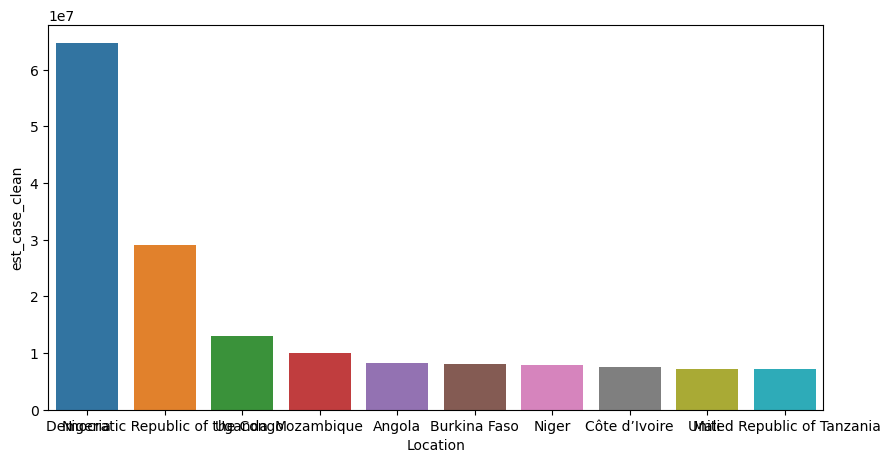

In [89]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=sorted_est_case_df.loc[sorted_est_case_df['Period'] == 2020].Location.head(
    10), y=sorted_est_case_df.loc[sorted_est_case_df['Period'] == 2020].est_case_clean.head(10))

In [90]:
# sorting by estimated deaths
sorted_est_death_df = est_df.sort_values(by='est_death_clean', ascending=False)
sorted_est_death_df.head()

,SpatialDimValueCode,Location,Period,est_case_clean,est_death_clean
2303,NGA,Nigeria,2000,51119378,249308
2204,NGA,Nigeria,2001,51130906,242521
1666,NGA,Nigeria,2006,58577749,232391
2092,NGA,Nigeria,2002,50530444,230496
1777,NGA,Nigeria,2005,56627136,230356


<AxesSubplot: xlabel='Location', ylabel='est_death_clean'>

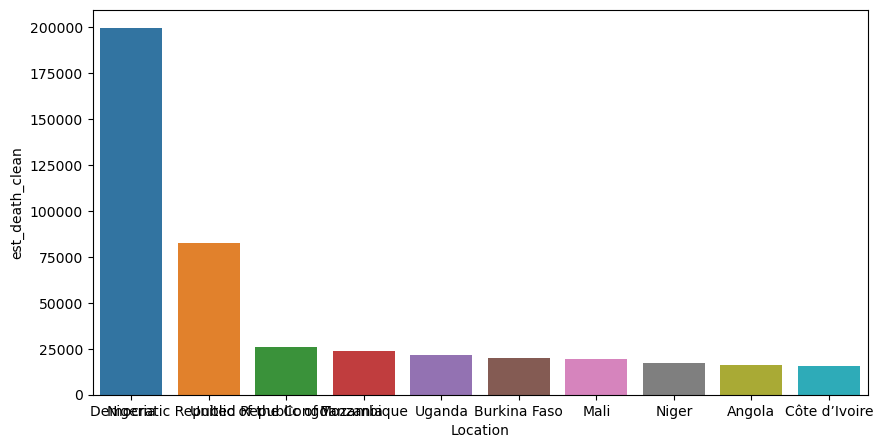

In [91]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=sorted_est_death_df.loc[sorted_est_death_df['Period'] == 2020].Location.head(
    10), y=sorted_est_death_df.loc[sorted_est_death_df['Period'] == 2020].est_death_clean.head(10))

<AxesSubplot: xlabel='Period', ylabel='est_case_clean'>

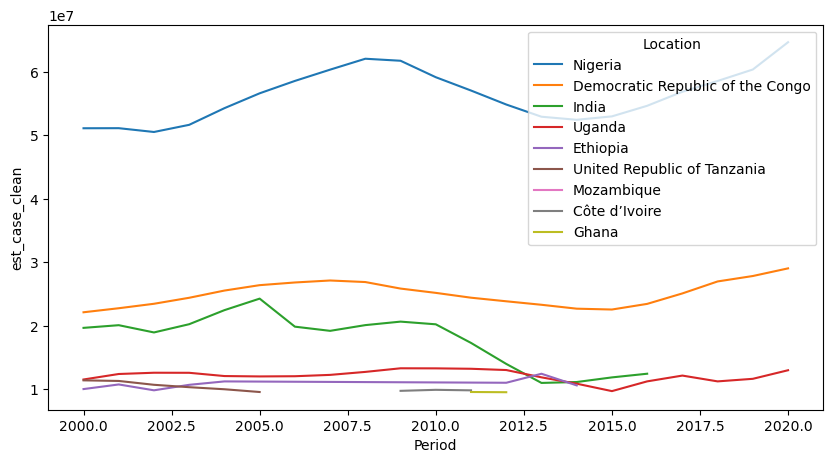

In [97]:
# will need to find a better way to choose which countries to include
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=sorted_est_case_df.head(100), x='Period', y='est_case_clean', hue='Location')

In [105]:
# top 10 countries by est death
list(sorted_est_death_df.loc[sorted_est_death_df['Period'] == 2020].Location.head(10))

['Nigeria',
 'Democratic Republic of the Congo',
 'United Republic of Tanzania',
 'Mozambique',
 'Uganda',
 'Burkina Faso',
 'Mali',
 'Niger',
 'Angola',
 'Côte d’Ivoire']

In [114]:
sorted_est_death_df.loc[sorted_est_death_df['Location'].isin(['Nigeria',
 'Democratic Republic of the Congo',
 'United Republic of Tanzania',
 'Mozambique',
 'Uganda',
 'Burkina Faso',
 'Mali',
 'Niger',
 'Angola',
 'Côte d’Ivoire'])]

,SpatialDimValueCode,Location,Period,est_case_clean,est_death_clean
2303,NGA,Nigeria,2000,51119378,249308
2204,NGA,Nigeria,2001,51130906,242521
1666,NGA,Nigeria,2006,58577749,232391
2092,NGA,Nigeria,2002,50530444,230496
1777,NGA,Nigeria,2005,56627136,230356
1565,NGA,Nigeria,2007,60355724,229172
1882,NGA,Nigeria,2004,54284280,226562
1988,NGA,Nigeria,2003,51659556,226464
1453,NGA,Nigeria,2008,62075250,221424
1347,NGA,Nigeria,2009,61757109,210258


<AxesSubplot: xlabel='Period', ylabel='est_case_clean'>

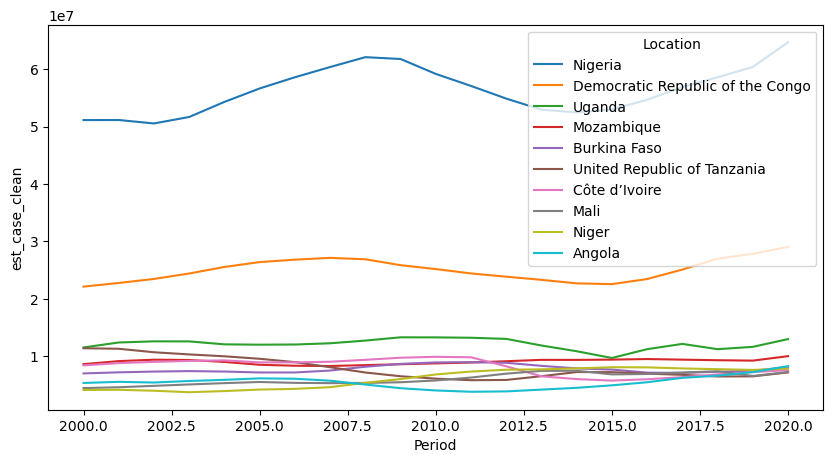

In [115]:
# plotting estimated cases
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=sorted_est_death_df.loc[sorted_est_death_df['Location'].isin(['Nigeria',
 'Democratic Republic of the Congo',
 'United Republic of Tanzania',
 'Mozambique',
 'Uganda',
 'Burkina Faso',
 'Mali',
 'Niger',
 'Angola',
 'Côte d’Ivoire'])], x='Period', y='est_case_clean', hue='Location')

<AxesSubplot: xlabel='Period', ylabel='est_death_clean'>

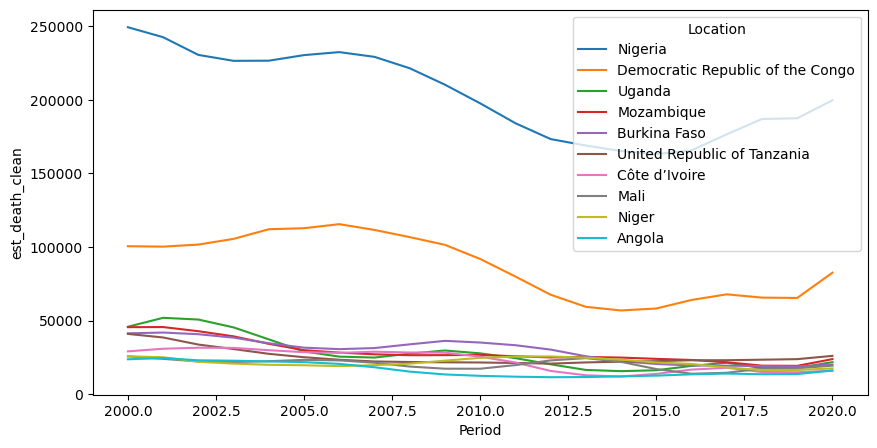

In [116]:
# plotting estimated deaths
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=sorted_est_death_df.loc[sorted_est_death_df['Location'].isin(['Nigeria',
 'Democratic Republic of the Congo',
 'United Republic of Tanzania',
 'Mozambique',
 'Uganda',
 'Burkina Faso',
 'Mali',
 'Niger',
 'Angola',
 'Côte d’Ivoire'])], x='Period', y='est_death_clean', hue='Location')

In [119]:
conf_case_clean_df.head()

,SpatialDimValueCode,Location,Period,conf_case_clean
0,BLZ,Belize,2020,0
1,TJK,Tajikistan,2020,0
2,TCD,Chad,2020,1544194
3,SDN,Sudan,2020,1698394
4,CAF,Central African Republic,2020,1740970


In [120]:
conf_case_clean_df.loc[conf_case_clean_df['Location'].isin(['Nigeria',
 'Democratic Republic of the Congo',
 'United Republic of Tanzania',
 'Mozambique',
 'Uganda',
 'Burkina Faso',
 'Mali',
 'Niger',
 'Angola',
 'Côte d’Ivoire'])].head()

,SpatialDimValueCode,Location,Period,conf_case_clean
8,BFA,Burkina Faso,2020,10600340
13,MOZ,Mozambique,2020,11318685
18,UGA,Uganda,2020,14196657
26,NGA,Nigeria,2020,18325240
34,MLI,Mali,2020,2666266


<AxesSubplot: xlabel='Period', ylabel='conf_case_clean'>

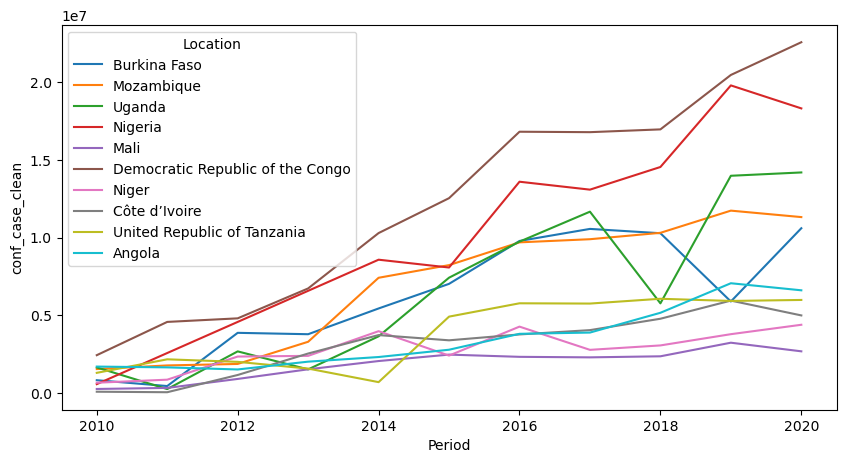

In [122]:
# plotting confirmed cases
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=conf_case_clean_df.loc[conf_case_clean_df['Location'].isin(['Nigeria',
 'Democratic Republic of the Congo',
 'United Republic of Tanzania',
 'Mozambique',
 'Uganda',
 'Burkina Faso',
 'Mali',
 'Niger',
 'Angola',
 'Côte d’Ivoire'])], x='Period', y='conf_case_clean', hue='Location')